### Итоговое задание Соколова Александра  
### по Проекту 3. О вкусной и здоровой пище (SF-DST-10)
####  Юнит 3. Введение в машинное обучение (отредактирован 15.06.2020)
---

### Импорт библиотек

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from IPython.display import display
pd.options.mode.chained_assignment = None

In [5]:
# import my_module as my

In [ ]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('15/06/2020')

### Импорт данных

In [4]:
path_to_file = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(path_to_file+'main_task.csv')
df_test = pd.read_csv(path_to_file+'kaggle_task.csv')
pd.set_option('display.max_columns', 200)
display(df_train.head(2))
display(df_test.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

### Предварительный анализ данных

In [6]:
# предварительный анализ данных с помощью библиотеки pandas_profiling закомментирован так как отображается не корректно
# pandas_profiling.ProfileReport(df_train)

### Детальный анализ по переменным
---
### 1. Restaurant_id

In [7]:
df['code_Restaurant_id'] = df['Restaurant_id'].apply(lambda x: float(x[3:]))

Резюме - Restaurant_id: Визуальный осмотр показал, что код Restaurant_id очень сильно похож на Ranking в data_train. Надо проверить корреляцию и при необходимости удалить 'code_Restaurant_id'

### 2. Cuisine Style

In [8]:
# в переменной 9283 (23.2%) пропущенных значений 
# сохраним эту информацию
df['NAN_Cuisine Style'] = pd.isna(df['Cuisine Style']).astype('float64') 

# заполним пропуски значением 'Other'
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")

# закодируем значения в переменной до их преобразования
le = LabelEncoder()
le.fit(df['Cuisine Style'])
df['code_Cuisine Style'] = le.transform(df['Cuisine Style'])

In [9]:
# проведем обработку значений переменной
df['Cuisine Style'] = df['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 

temp_list = df['Cuisine Style'].tolist()

def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
      result.extend(lst)
    return result

temp_counter=Counter(list_unrar(temp_list))

In [10]:
# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
df['unique_Cuisine_Style'] = df['Cuisine Style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

In [11]:
for cuisine in temp_counter:
    df[cuisine] = df['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0 ).astype('float64')

# генерируем новый признак кол-во кухонь в ресторане
df['count_Cuisine_Style'] = df['Cuisine Style'].apply(lambda x: len(x)).astype('float64')

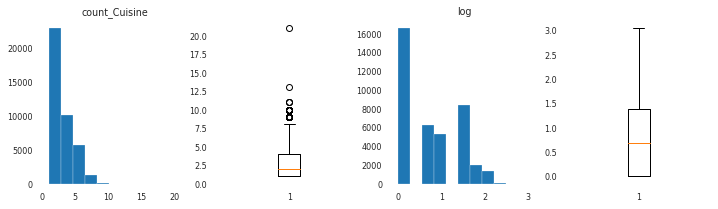

In [12]:
my.four_plot_with_log('count_Cuisine', df[df['Sample'] == 1].count_Cuisine_Style)

In [13]:
# видимо в значениях есть нули, это значит что это не Other, а просто не заполненные. проверим
my.describe_without_plots('count_Cuisine_Style', df[df['Sample'] == 1].count_Cuisine_Style)

,count_Cuisine_Style
кол-во строк,40000
тип значений,float64
кол-во значений,40000
кол-во NaN,0
среднее,2.6224
медиана,2
мин,1
макс,21


***Резюме - Cuisine Style:*** Много пропусков 9283 (23.2%). Чтобы сохранить эту информацию сформирован новый признак 'NAN_Cuisine Style'. С помощью интелектуального кодера закодировал изначальные значения и ввел новый критерий - 'code_Cuisine Style'. Значения критерия обработаны с помощью регулярных выражений, чтобы составить статистику по типам кухонь. По самым не популярным составлен признак - 'unique_Cuisine_Style'. Кроме этого, после обработки, добавлен критерий количества типов кухонь в ресторане 'count_Cuisine_Style'. В новом признаке выбросов нет. В исходном критерии все типы кухонь были заполнены, \[\] пустых списков не было.

### 3. Price Range

In [14]:
# в переменной очень много пропусков 13886 (34.7%)
# сохраним информацию о пропусках чтобы не потерять
df['NaN_Price Range'] = pd.isna(df['Price Range']).astype('float64') 

# заполним значения в переменной по словарю
dic_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
df['Price_Range']=df['Price Range'].map(lambda x: dic_value_Price.get(x,x))

# 18412 ресторанов это более 70% из заполненной информации имеют средний параметр цены
# поэтому заполняем пропуски двойкой (2)
df['Price_Range'] = df['Price_Range'].fillna(2)

,Price Range
кол-во строк,40000
тип значений,float64
кол-во значений,40000
кол-во NaN,0
среднее,1.8786
медиана,2
мин,1
макс,3


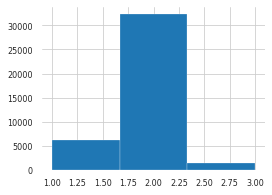

In [15]:
# проверим полученный критерий
my.describe_with_hist('Price Range', df[df['Sample'] == 1].Price_Range)

***Резюме - Price Range:*** в переменной очень много пропусков 13886 (34.7%). Чтобы не потерять информацию о пропусках создан новый критерий - 'NaN_Price Range'. Также создан новый признак числового кодирования цены - 'Price_Range' (низкая цена - 1, средняя цена -2 , высокая цена - 3).  Пропуски заполнили модой - средней ценой (двойкой). 

### 4. Number of Reviews

In [16]:
# в переменной 2543 (6.4%) пропущенных значений 
# сохраним эту информацию
df['NAN_Number of Reviews'] = pd.isna(df['Number of Reviews']).astype('float64')

# для удобства изменим название столбца
df.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

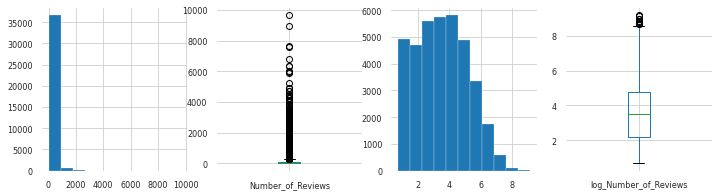

In [17]:
my.four_plot_with_log2('Number_of_Reviews', df[df['Sample'] == 1])

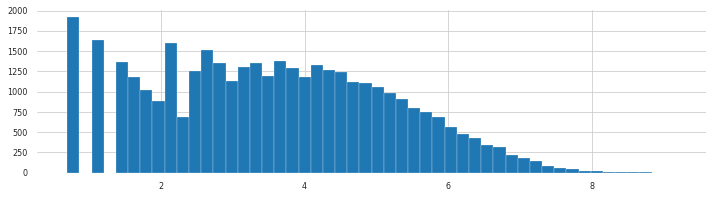

In [18]:
# выбросы есть, купол распределения с точками перегиба, необходимо посмотреть на гистограмму по крупнее
my.big_hist_log('Number_of_Reviews', df[df['Sample'] == 1])

In [19]:
# посмотрим на границы
my.borders_of_outliers('Number_of_Reviews', df[df['Sample'] == 1], log=True)

,левая,правая
границы выбросов с логарифмом,-1.624337,8.566493
границы выбросов без логарифма,0.197042,5252.678628
кол-во значений за границей,0.000000,10.000000


In [20]:
# выбросов не так много, удалим их, предварительно сохранив информацию о них
df['outliers_Number_of_Reviews'] = pd.DataFrame(df['Number_of_Reviews']>5252).astype('float64')
df.loc[df['Number_of_Reviews']>5252, 'Number_of_Reviews']=None

***Резюме - Number of Reviews*** 2543 (6.4%) пропусков.  
Странный вид прологарифмированного распределения, как будто в нем два распределения причем одно логнормальное, а другое распределение Бернули при малом кол-ве кухонь. Второе распределение может быть искуственным снижением или удалением кол-ва отзывов (возможно за "фейковые" отзывы или "накрутки")  Необходимо попытаться сделать срезы на других переменных (City) или на новых переменных (Population и т.п.), если хватит времени.  
Выбросов 10. Удалил. Сохранил информацию о них в отдельной переменной.

### 5. Reviews

In [21]:
# в ревью нет пропусков, но 6471 строк со значением [[], []]. По сути это пустые строки сохраним их 
df['empty_Reviews'] = (df['Reviews']=='[[], []]').astype('float64')

# анализ тестовой базы выявил два пропуска, несмотря на то, что pandas.profiling на тренировочной базе пропусков не выявил, заполним их '[[], []]' и закинем в empty_Reviews
df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['empty_Reviews'] = (df['Reviews']=='[[], []]').astype('float64')

In [22]:
# вытащим дату из ревью и создадим новые критерии
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')
df['len_date'] = df['date_of_Review'].apply(lambda x: len(x))

# проверим длину дат, на случай если там больше или меньше двух (2)
my.describe_without_plots('len_date', df[df['Sample'] == 1].len_date)

,len_date
кол-во строк,40000
тип значений,int64
кол-во значений,40000
кол-во NaN,0
среднее,1.5626
медиана,2
мин,0
макс,3


In [23]:
# есть значение 3 надо разобраться что там
print("кол-во значений Reviews с тремя датами :=" , len(df[df['len_date']==3]))
print("значения Reviews с тремя датами :=")
temp_list = df[df['len_date']==3].Reviews.to_list()
display(df[df['len_date']==3].Reviews.to_list())
print("даты после обработки регулярными выражениями:")
display([re.findall('\d+/\d+/\d+', x) for x in temp_list])

кол-во значений Reviews с тремя датами := 4
значения Reviews с тремя датами :=


["[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]",
 "[['Good Museum Cafeteria', 'Lunch 30/5/2017'], ['04/13/2017', '05/30/2017']]",
 "[['The desserts arcade !', 'Visit today 3/1/2017'], ['06/02/2017', '01/03/2017']]",
 "[['lunch 29/9/2016', 'Unplanned Great Dinner'], ['09/30/2016', '08/25/2016']]"]

даты после обработки регулярными выражениями:


[['21/10/17', '12/22/2017', '10/19/2017'],
 ['30/5/2017', '04/13/2017', '05/30/2017'],
 ['3/1/2017', '06/02/2017', '01/03/2017'],
 ['29/9/2016', '09/30/2016', '08/25/2016']]

In [24]:
# видим что люди указывали даты в отзывах и эти даты попали в обработку
# из-за этого возникнут ошибки так как даты не верные и их формат отличается и формата выгрузки
# при этом таких строк всего четыре (4), можно было бы их не исправлять а выбросить потому что 17 
# год явно приведет к выбросу с которым надо будет разбираться. Выбрасывать жалко, тогда исправим,
# тем более, что это достачно просто

df['len_date'].date_of_Review = df[df['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))

In [25]:
# также есть значение 1 надо разобраться что там
print("кол-во значений Reviews с одной датой :=" , len(df[df['len_date']==1]))
display(df[df['len_date']==1].Reviews[:4])

кол-во значений Reviews с одной датой := 5680


12    [['You always feel very Welcome at this cozy.....
31                 [['Very good food'], ['09/24/2017']]
48                         [['Thomas'], ['01/06/2016']]
50    [['The best in Budapest so far'], ['03/05/2017']]
Name: Reviews, dtype: object

In [26]:
# оказалось, что есть отзывы с одним (1) отзывом и их достаточно много 5680 из (40000-6471) это 17%
# сохраним это на всякий случай, чтобы не потерять
df['one_Review'] = (df['len_date']==1).astype('float64')

# заполним перерыв между отзывами (по отзывам где len = 2) и насколько давно был сделан последний самый свежий отзыв
# создадим для этого функции:
def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

df['day_to_now'] = df.apply(time_to_now, axis = 1).dt.days
df['day_between_Reviews'] = df[df['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days

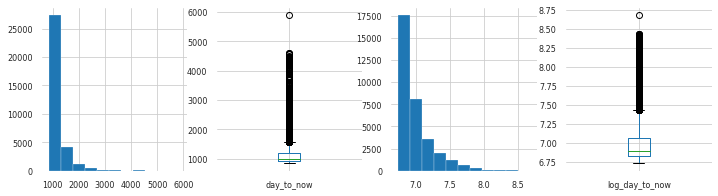

In [27]:
# посмотрим на критерий day_to_now - это насколько давно был сделан последний самый свежий отзыв в днях
my.four_plot_with_log2('day_to_now', df[df['Sample'] == 1])

In [28]:
# выбросов достаточно много посмотрим на границы выбросов
my.borders_of_outliers('day_to_now', df[df['Sample'] == 1], log=True)

,левая,правая
границы выбросов с логарифмом,6.454848,7.440250
границы выбросов без логарифма,635.777090,1703.175558
кол-во значений за границей,0.000000,2356.000000


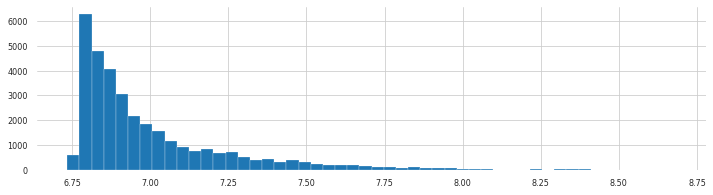

In [29]:
# жалко терять 2356 значений 
# посмотрим на гистограмму крупно
my.big_hist_log('day_to_now', df[df['Sample'] == 1])

In [30]:
# никаких очевидных аномалий не видно 
# посмотрим основные статистики
my.describe_without_plots('day_to_now', df[df['Sample'] == 1].day_to_now)

,day_to_now
кол-во строк,40000
тип значений,float64
кол-во значений,33529
кол-во NaN,6471
среднее,1130.37
медиана,994
мин,841
макс,5900


***Резюме - Reviews:*** Пропусков в тренировочном датасете нет, в тестовом - 2. Но есть 6471 незаполненных строк с отзывами в тренировочном датасете это 16% от датасета. В 5680 (14%) строках есть только один отзыв, хотя в подавляющем большинстве отзывов два.  
Созданы новые критерии:   
- empty_Reviews - незаполненные отзывы  
- date_of_Review - даты из отзывов  
- len_date - кол-во дат в отзыве  
- day_to_now - насколько давно был сделан последний самый свежий отзыв в днях  
- day_between_Reviews - перерыв между отзывами в днях

***Резюме - day_to_now из Reviews:*** Удаление по порогу не напрашивается так как компания TripAdvisor работает с 2000 года. Максимум 5896/365 ~ 16,5 лет от 2020 года укладывается в дату начала старта сайта. В выбросы попало 2365 (почти 6%) значений, с учетом резюме по неполным данным в критерии Reviews, я пока принимаю решение не избавлятся от выросов, построить модель, обратить внимание на важность критерия, и при необходимости вернуться к нему для заполнения парсингом или удаления выбросов

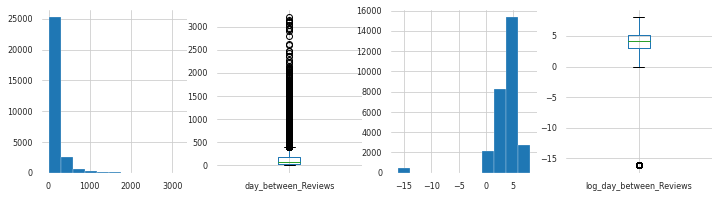

In [31]:
# теперь посмотрим на разницу в датах отзывов в днях 
my.four_plot_with_log2('day_between_Reviews', df[df['Sample'] == 1])

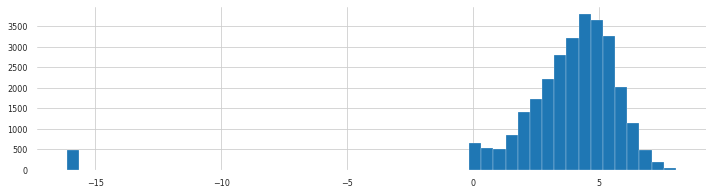

In [32]:
my.big_hist_log('day_between_Reviews', df[df['Sample'] == 1])

In [33]:
my.borders_of_outliers('day_between_Reviews', df[df['Sample'] == 1], log=True)

,левая,правая
границы выбросов с логарифмом,-0.240607,8.389631
границы выбросов без логарифма,0.786151,4401.191461
кол-во значений за границей,492.000000,0.000000


In [34]:
# кол-во выбросов 495 (1.2%) - это статистически не значимо, но мы пока сохраняем информацию о выбросе, а потом проверим его важность в модели
df['out_day_between_Reviews'] = (df['day_between_Reviews']==0).astype('float64')

# и удаляем выбросы
df.loc[df['day_between_Reviews']==0, 'day_between_Reviews'] = None

In [35]:
my.describe_without_plots('day_between_Reviews', df[df['Sample'] == 1].day_between_Reviews)

,day_between_Reviews
кол-во строк,40000
тип значений,float64
кол-во значений,28479
кол-во NaN,11521
среднее,144.164
медиана,69
мин,1
макс,3207


***Резюме - day_between_Reviews из Reviews:*** Заполнен слабо 70%. Удалены выбросы в нуле (492 значения). Создан новый критерий - out_day_between_Reviews  

<details>
  <summary>***Позитивный или негативный оттенок в отзывах***</summary>
    Этот пункт пока не проработан, по причине того, что мне кажется эффективнее потратить время на парсинг дополнительной информации, чем на обработку этого момента. Так как я решил пока не использовать парсинг и выжать максимум из модели, проработаю если хватит времени
  </details> 

### 6. ID_TA

In [36]:
df['code_ID_TA'] = df['ID_TA'].apply(lambda x: float(x[1:]))

### 7. URL_TA

In [37]:
df['code_after_g_URL_TA'] = df['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

### 8. City

In [38]:
df_City_dummies = pd.get_dummies(df['City'], dummy_na=False).astype('float64')
df = pd.concat([df,df_City_dummies], axis=1)

In [39]:
le = LabelEncoder()
le.fit(df['City'])
df['code_City'] = le.transform(df['City'])

### 8.1. Capital_City

In [40]:
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
df['Capital_City'] = df['City'].apply(lambda x: 0.0 if x in list_Of_NotCapitalCity else 1.0)

### 8.2. Сountries

In [41]:
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
df['Сountry'] = df.apply(lambda row: dict_Сountries[row['City']], axis = 1)

le = LabelEncoder()
le.fit(df['Сountry'])
df['code_Сountry'] = le.transform(df['Сountry'])

### 8.4. Сity_population

In [42]:
dict_Сity_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['Сity_population'] = df.apply(lambda row: dict_Сity_population[row['City']], axis = 1)

***Резюме - City:*** Без пропусков, категориальный признак. Сгенерированы новые признаки города по типу dummies, также создан новый критерий code_City с интелектуальной кодировкой LabelEncoder из библиотеки sklearn  
Добавлены новые критерии:  
- Capital_City - столица  
- code_Сountry - код страны с помощью LabelEncoder
- Сity_population - население города (тыс. чел.)  

### 9. Ranking

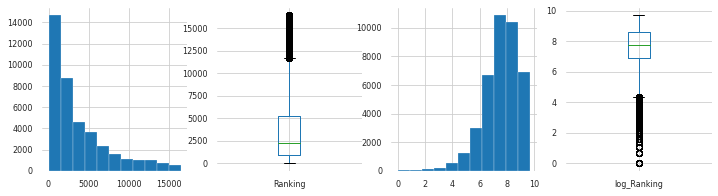

In [43]:
my.four_plot_with_log2('Ranking', df[df['Sample'] == 1])

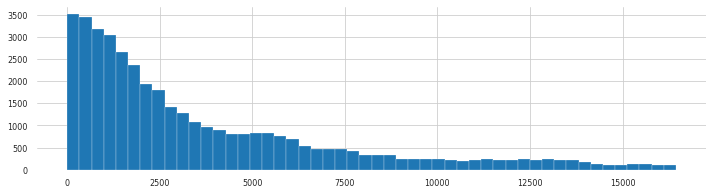

In [44]:
my.big_hist('Ranking', df[df['Sample'] == 1])

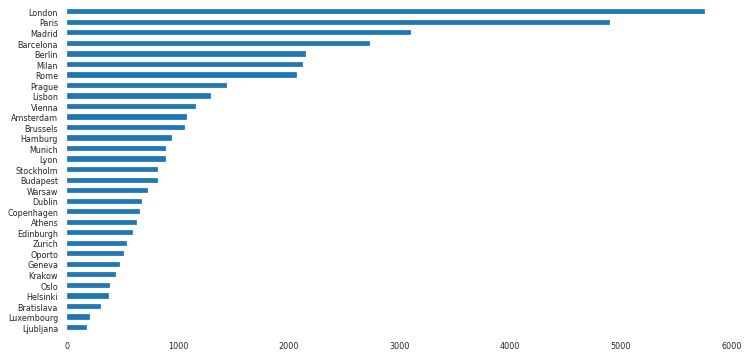

In [45]:
# У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?
plt.rcParams['figure.figsize'] = (12,6)
df_train['City'].value_counts(ascending=True).plot(kind='barh')

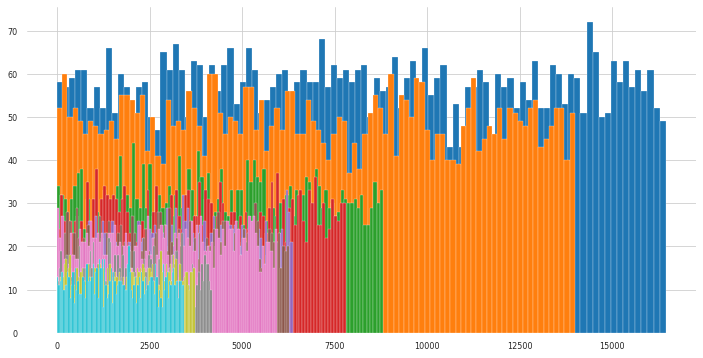

In [46]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [47]:
# Получается, что Ranking имеет нормальное распределение, 
# просто в больших городах больше ресторанов, из-за мы этого имеем смещение
# необходимо отнормировать критерий Ranking по городам City
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = df['City'].value_counts(ascending=False)
df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
df['count_Restorant_in_City'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
df['norm_Ranking_on_Rest_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['count_Restorant_in_City']

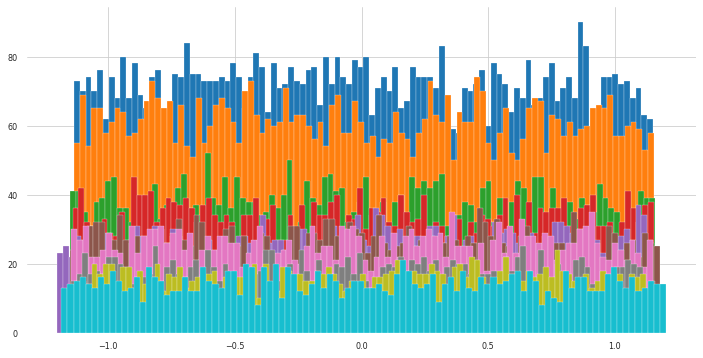

In [48]:
# посмотрим что получилось на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_Rest_in_City'][df['City'] == x].hist(bins=100)
plt.show()

In [49]:
max_Ranking_on_City = df.groupby(['City'])['Ranking'].max()
df['max_Ranking_on_City'] = df['City'].apply(lambda x: max_Ranking_on_City[x])
df['norm_Ranking_on_maxRank_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['max_Ranking_on_City']

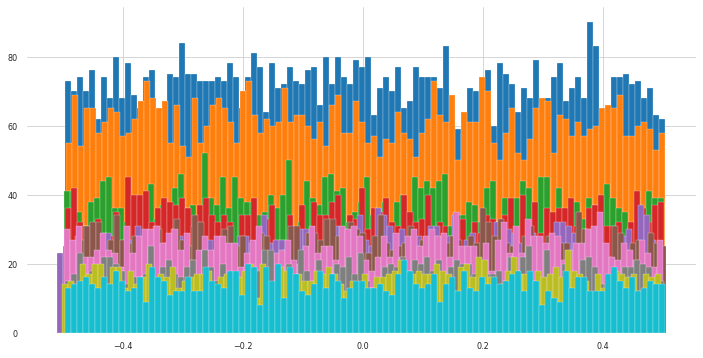

In [50]:
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_maxRank_in_City'][df['City'] == x].hist(bins=100)
plt.show()

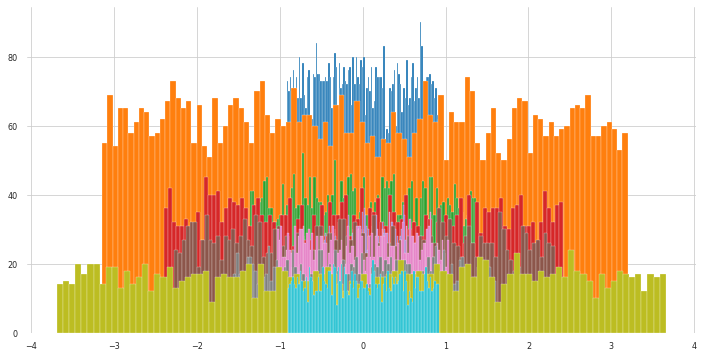

In [51]:
# критерий Ranking по населению в городах Population_Сity
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
df['norm_Ranking_on_Popul_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['Сity_population']

for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_Popul_in_City'][df['City'] == x].hist(bins=100)
plt.show()

In [52]:
df['norm_Population_on_Rest'] = df['Сity_population']/df['count_Restorant_in_City']

### Построчная верификация первых двух строк

In [53]:
display(df.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Sample,Rating,code_Restaurant_id,NAN_Cuisine Style,code_Cuisine Style,unique_Cuisine_Style,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,German,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,count_Cuisine_Style,NaN_Price Range,Price_Range,NAN_Number of Reviews,outliers_Number_of_Reviews,empty_Reviews,date_of_Review,len_date,one_Review,day_to_now,day_between_Reviews,out_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_City,Capital_City,Сountry,code_Сountry,Сity_population,mean_Ranking_on_City,count_Restorant_in_City,norm_Ranking_on_Rest_in_City,max_Ranking_on_City,norm_Ranking_on_maxRank_in_City,norm_Ranking_on_Popul_in_City,norm_Population_on_Rest
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,0.0,1778,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,[],0,0.0,NaN,NaN,0.0,10746918.0,187147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24,1.0,France,6,2206,6938.557138,6108,0.986320,13986.0,0.430748,2.730935,0.361166
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,0.0,4076,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,"[12/05/2017, 10/29/2017]",2,0.0,924.0,37.0,0.0,6674944.0,189934.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,1.0,Finland,5,643,564.231579,475,-0.964698,1141.0,-0.

### Удаление не числовых столбцов

In [54]:
df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'len_date', 'Сountry', 'Сity_population', 'mean_Ranking_on_City', 'count_Restorant_in_City', 'max_Ranking_on_City', ], axis=1, inplace=True, errors='ignore')

### Стандартизируем и заполняем нулями пропуски по всем переменным

In [55]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(df[[d_col]])
    return scaler.transform(df[[d_col]])
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(df.columns):
    if i not in ['Rating','Sample']:
        df[i] = StandardScaler_column(i)
        if len(df[df[i].isna()]) < len(df):
            df[i] = df[i].fillna(0)

In [56]:
# проверяем заполнение
display(df.describe().head(1))

,Ranking,Number_of_Reviews,Sample,Rating,code_Restaurant_id,NAN_Cuisine Style,code_Cuisine Style,unique_Cuisine_Style,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,German,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,count_Cuisine_Style,NaN_Price Range,Price_Range,NAN_Number of Reviews,outliers_Number_of_Reviews,empty_Reviews,one_Review,day_to_now,day_between_Reviews,out_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_City,Capital_City,code_Сountry,norm_Ranking_on_Rest_in_City,norm_Ranking_on_maxRank_in_City,norm_Ranking_on_Popul_in_City,norm_Population_on_Rest
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


### Разбиваем датасет на тренировочный и тестовый

In [57]:
train_data = df.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [58]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [59]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 183), (40000, 183), (40000, 182), (32000, 182), (8000, 182))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [60]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [61]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
# функция стандартного математического округления
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

# функция округления кратно 0.5
def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5
    
# создание функции для векторов np
my_vec_round = np.vectorize(my_round)

In [63]:
y_pred = my_vec_round(y_pred)

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.1645625


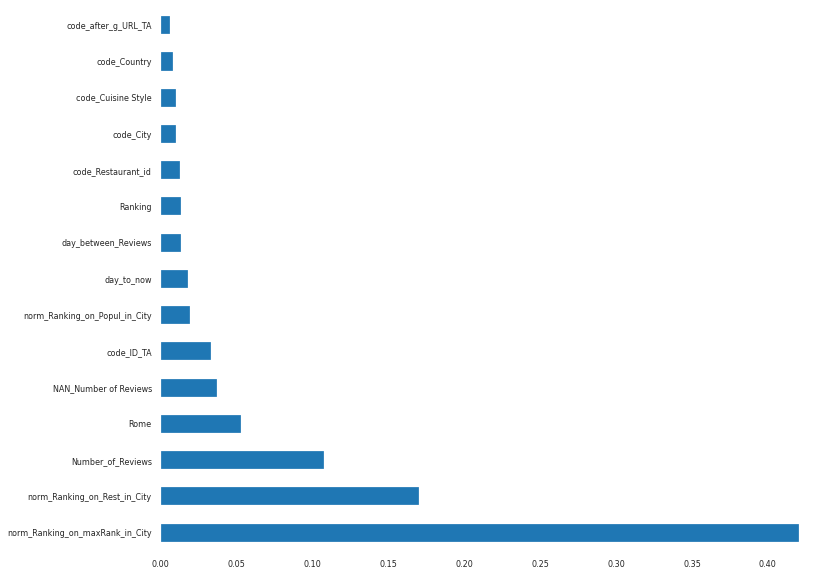

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Проверяем корреляцию важных переменных и применяем метод главных компонент (PCA)

(15.5, -0.5)

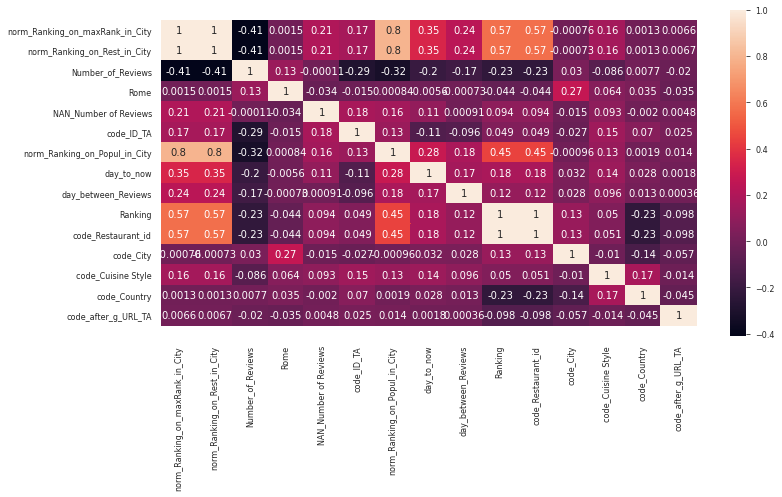

In [66]:
df_temp = df.loc[df['Sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [67]:
list_temp = list(feat_importances.nlargest(15).index[[9,10]])
display(df_temp[list_temp].corr())

,Ranking,code_Restaurant_id
Ranking,1.0,1.0
code_Restaurant_id,1.0,1.0


In [68]:
# вспоминаем Резюме по критерию code_Restaurant_id. Удаляем так как была гипотеза о корреляции с Ranking
df.drop(['code_Restaurant_id'], axis=1, inplace=True, errors='ignore')

In [69]:
list_temp = list(feat_importances.nlargest(15).index[[0,1,6,10]])
df_temp[list_temp].corr()

,norm_Ranking_on_maxRank_in_City,norm_Ranking_on_Rest_in_City,norm_Ranking_on_Popul_in_City,code_Restaurant_id
norm_Ranking_on_maxRank_in_City,1.000000,0.999832,0.800703,0.574781
norm_Ranking_on_Rest_in_City,0.999832,1.000000,0.797947,0.570877
norm_Ranking_on_Popul_in_City,0.800703,0.797947,1.000000,0.448070
code_Restaurant_id,0.574781,0.570877,0.448070,1.000000


In [70]:
# Метод главных компонент, PCA
C = np.array([
    [       1, 0.999832, 0.800703, 0.574781],
    [0.999832,        1, 0.796851, 0.570877],
    [0.800703, 0.796851,        1, 0.448070],
    [0.574781, 0.570877, 0.448070,        1]]) 
eig_num, eig_v = np.linalg.eig(C)
print(f"вектор главных компонент := {eig_v[:,0]}")

вектор главных компонент := [0.54791659 0.54681616 0.49296257 0.39719945]


In [71]:
df['norm_Ranking_PCA'] = eig_v[:,0][0]*df['norm_Ranking_on_maxRank_in_City'] + eig_v[:,0][1]*df['norm_Ranking_on_Rest_in_City'] + eig_v[:,0][2]*df['norm_Ranking_on_Popul_in_City']+eig_v[:,0][3]*df['Ranking']

### Добавим критерии используя полиномиальный принцип

In [72]:
df['Ranking_on_square'] = df['Ranking']* df['Ranking']
df['doble_Ranking'] = df['Ranking']

### Тестирование оптимального набора критериев

описание работы блока тестирования оптимального набора:  
1. сохраняем список всех критериев по важности 
2. перебираем по очереди все критерии и удаляем их по одному из датасета
3. после удаления критерия строим модель, считаем МАЕ и записываем результат в лог
4. после перебора всех критериев печатаем весь лог и сортируем по возрастанию МАЕ
5. выбираем самый минимальный МАЕ удаляем из датасета и повторяем перебор пока МАЕ уменьшается
6. формируем список критериев на удаление

In [73]:
# блок тестирования закомментирован так как список критериев для удаления с помощью него уже был сгенерирован
# # блок тестирования оптимального набора
# list_ofAllColumnsSortImportant = list(feat_importances.nlargest(len(train_data.columns)-1).index)
# min_MAE = round(MAE,3)
# print(f"min_MAE = {min_MAE}")
# remove_list = []
# log = []
# delta =0.002
# for i in range(0,len(list_ofAllColumnsSortImportant),1):
#     col = list_ofAllColumnsSortImportant[i]
#     print(f"{i}.{col}")
#     ###
#     train_data = df.query('Sample == 1').drop(['Sample']+drop_list2, axis=1)
#     test_data = df.query('Sample == 0').drop(['Sample']+drop_list2, axis=1)

#     y = train_data.Rating.values            # наш таргет
#     X = train_data.drop(['Rating']+[col], axis=1)

#     # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
#     # выделим 20% данных на валидацию (параметр test_size)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
#     print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_pred = my_vec_round(y_pred)
#     temp_MAE = metrics.mean_absolute_error(y_test, y_pred)
#     ###
#     print(temp_MAE)
#     log.append([col, temp_MAE])
#     if round(temp_MAE,3) <= min_MAE-delta:
#         remove_list.append(col)
#         print(f"удаляем:= {col}")
#     else:
#         print(f"не удаляем:= {col}")
# print(f"i={i}")
# print(f"remove_list: {remove_list}")
# print(f"log_list: {log}")

In [74]:
log_list = ['out_day_between_Reviews', 0.163], ['Ranking', 0.1631875], ['Burmese', 0.163375], ['Georgian', 0.1635], ['Fusion', 0.1635625], ['Balti', 0.1635625], ['Tibetan', 0.1636875], ['norm_Ranking_PCA', 0.16375], ['Scottish', 0.16375], ['Eastern European', 0.16375], ['norm_Ranking_on_Rest_in_City', 0.1638125], ['count_Cuisine_Style', 0.1638125], ['Ethiopian', 0.1638125], ['Minority Chinese', 0.1638125], ['Madrid', 0.163875], ['Portuguese', 0.163875], ['Delicatessen', 0.163875], ['Halal', 0.163875], ['Azerbaijani', 0.163875], ['Caucasian', 0.163875], ['Geneva', 0.1639375], ['Scandinavian', 0.1639375], ['Uzbek', 0.1639375], ['Polynesian', 0.164], ['Price_Range', 0.1640625], ['Healthy', 0.1640625], ['Cuban', 0.1640625], ['Dublin', 0.164125], ['Peruvian', 0.164125], ['Salvadoran', 0.164125], ['Sushi', 0.1641875], ['Central European', 0.1641875], ['Venezuelan', 0.1641875], ['Capital_City', 0.16425], ['Gluten Free Options', 0.16425], ['Athens', 0.16425], ['Lebanese', 0.16425], ['Brew Pub', 0.16425], ['Taiwanese', 0.16425], ['Spanish', 0.1643125], ['African', 0.1643125], ['Lisbon', 0.1643125], ['Russian', 0.1643125], ['Central Asian', 0.1643125], ['Singaporean', 0.1643125], ['code_Сountry', 0.164375], ['Italian', 0.164375], ['Wine Bar', 0.164375], ['Barcelona', 0.164375], ['Diner', 0.164375], ['Arabic', 0.164375], ['Filipino', 0.164375], ['Xinjiang', 0.164375], ['Krakow', 0.1644375], ['Lyon', 0.1644375], ['London', 0.1644375], ['unique_Cuisine_Style', 0.1644375], ['European', 0.1645], ['Oporto', 0.1645], ['Contemporary', 0.1645], ['Vienna', 0.1645], ['Croatian', 0.1645], ['Romanian', 0.1645], ['Southwestern', 0.1645], ['Cambodian', 0.1645], ['Vegetarian Friendly', 0.1645625], ['Milan', 0.1645625], ['Egyptian', 0.1645625], ['Fujian', 0.1645625], ['Ranking_on_square', 0.164625], ['German', 0.164625], ['Thai', 0.164625], ['Brussels', 0.164625], ['Cajun & Creole', 0.164625], ['Colombian', 0.164625], ['Kosher', 0.164625], ['Indian', 0.1646875], ['Oslo', 0.1646875], ['Ecuadorean', 0.1646875], ['Latvian', 0.1646875], ['Fast Food', 0.16475], ['Grill', 0.16475], ['Prague', 0.16475], ['Czech', 0.16475], ['New Zealand', 0.16475], ['French', 0.1648125], ['Ljubljana', 0.1648125], ['Argentinean', 0.1648125], ['Stockholm', 0.164875], ['South American', 0.164875], ['Moroccan', 0.164875], ['Jamaican', 0.164875], ['Native American', 0.164875], ['Bar', 0.1649375], ['Asian', 0.1649375], ['Belgian', 0.1649375], ['Luxembourg', 0.1649375], ['Irish', 0.1649375], ['Rome', 0.165], ['Mediterranean', 0.165], ['Vietnamese', 0.165], ['Sri Lankan', 0.165], ['Afghani', 0.165], ['Seafood', 0.1650625], ['Budapest', 0.1650625], ['Hungarian', 0.1650625], ['Vegan Options', 0.165125], ['Chilean', 0.165125], ['Pub', 0.1651875], ['NAN_Cuisine Style', 0.1651875], ['Polish', 0.1651875], ['code_after_g_URL_TA', 0.16525], ['Street Food', 0.16525], ['Copenhagen', 0.16525], ['Ukrainian', 0.16525], ['Israeli', 0.16525], ['Slovenian', 0.16525], ['Albanian', 0.16525], ['NAN_Number of Reviews', 0.1653125], ['Brazilian', 0.1653125], ['Swedish', 0.1653125], ['Paris', 0.165375], ['Middle Eastern', 0.1654375], ['Munich', 0.1654375], ['Cafe', 0.1655], ['Other', 0.1655], ['Chinese', 0.1655], ['Berlin', 0.1655], ['Pizza', 0.1655625], ['International', 0.1655625], ['Pakistani', 0.1655625], ['Swiss', 0.1655625], ['Norwegian', 0.1655625], ['Bratislava', 0.165625], ['Steakhouse', 0.165625], ['Zurich', 0.165625], ['Mongolian', 0.165625], ['Canadian', 0.165625], ['Dutch', 0.1656875], ['British', 0.1656875], ['Danish', 0.1656875], ['Barbecue', 0.1656875], ['Austrian', 0.1656875], ['Gastropub', 0.16575], ['Nepali', 0.16575], ['Latin', 0.16575], ['Caribbean', 0.16575], ['Helsinki', 0.1658125], ['Armenian', 0.1658125], ['Central American', 0.165875], ['Welsh', 0.165875], ['Edinburgh', 0.1660625], ['norm_Ranking_on_maxRank_in_City', 0.166125], ['Tunisian', 0.166125], ['day_between_Reviews', 0.1661875], ['code_City', 0.166375], ['NaN_Price Range', 0.1666875], ['Greek', 0.1668125], ['day_to_now', 0.1669375], ['code_ID_TA', 0.1691875], ['Number_of_Reviews', 0.2305625]

In [75]:
drop_list = ['Australian', 'one_Review', 'outliers_Number_of_Reviews', 'norm_Ranking_on_Popul_in_City', 'Korean', 'Japanese', 'Turkish', 'Malaysian', 'Indonesian', 'Hawaiian', 'code_Cuisine Style', 'norm_Population_on_Rest', 'Amsterdam', 'Hamburg', 'doble_Ranking', 'Warsaw', 'Persian', 'Soups', 'Mexican', 'Bangladeshi', 'Yunnan', 'American', 'empty_Reviews']

### Submission

In [76]:
train_data = df.query('Sample == 1').drop(['Sample']+drop_list, axis=1)
test_data = df.query('Sample == 0').drop(['Sample','Rating']+drop_list, axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [77]:
sample_submission = pd.read_csv(path_to_file+'sample_submission.csv')
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [78]:
sample_submission.shape, test_data.shape, X.shape, y.shape

((10000, 2), (10000, 161), (40000, 161), (40000,))

In [79]:
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [80]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [81]:
predict_submission=my_vec_round(predict_submission)
predict_submission

array([3., 4., 4., ..., 3., 4., 4.])

In [82]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5


Спасибо за внимание!  
Описание к ноутбуку и его полную версию вы можете увидеть на GitHub
https://github.com/alex-sokolov2011/skillfactory_rds/tree/master/module_3